<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Starter**

In this notebook we will learn how to use Recurrent All-Pairs Field Transforms (RAFT) for DIC

## **RAFT-DIC Models**

RAFT trained models:

 - raft-DIC


Clone the repo and import libraries

In [1]:
!git clone https://github.com/UTAmegg/RAFT-DIC.git

Cloning into 'RAFT-DIC'...


In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [4]:
sys.path.append('RAFT-DIC/core')


c:\Users\13014\OneDrive - The University of Texas at Austin\Documents\Python Codes\RAFT-DIC


Load the images from the Github

(1) For .tif format of images

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 指定本地图片路径
img_dir = "RAFT-DIC/examples/Quadratic/"
ref_path = os.path.join(img_dir, "reference.tif") 
def_path = os.path.join(img_dir, "deformed.tif")


def load_and_resize_image(img_path, scale_factor=1/1):
    """从本地加载并调整图片大小"""
    # 读取图片
    frame = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    
    if frame is None:
        raise Exception(f"Failed to load image from {img_path}")

    # 调整大小
    original_height, original_width = frame.shape[:2]
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
    # BGR转RGB
    resized_frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

    return resized_frame_rgb

try:
    # 加载两张图片
    frame1_resized = load_and_resize_image(ref_path)
    frame2_resized = load_and_resize_image(def_path)

    # 显示图片
    _, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(frame1_resized)
    ax[0].set_title("Frame 1")
    ax[1].imshow(frame2_resized)
    ax[1].set_title("Frame 2")

    plt.show()
except Exception as e:
    print(f"Error: {e}")

# 移除了frame1_resized.type,因为numpy数组没有type属性
print(f"Image shape: {frame1_resized.shape}")
print(f"Image dtype: {frame1_resized.dtype}")

c:\Users\13014\OneDrive - The University of Texas at Austin\Documents\Python Codes\RAFT-DIC
RAFT-DIC/examples/Quadratic/reference.tif
Error: Failed to load image from RAFT-DIC/examples/Quadratic/deformed.tif
Image shape: (256, 256, 3)
Image dtype: uint8


Cutting images

Processing reference image...
Total cropped images saved: 4
Window 0 overlaps with:
  - Window 2 (down) at (0, 56, 200, 200)
  - Window 1 (right) at (56, 0, 200, 200)
Window 1 overlaps with:
  - Window 3 (down) at (56, 56, 256, 200)
  - Window 0 (left) at (56, 0, 200, 200)
Window 2 overlaps with:
  - Window 0 (up) at (0, 56, 200, 200)
  - Window 3 (right) at (56, 56, 200, 256)
Window 3 overlaps with:
  - Window 1 (up) at (56, 56, 256, 200)
  - Window 2 (left) at (56, 56, 200, 256)
Final displacement field saved as 'final_displacement.npy'


<ipython-input-30-cf22a40bc001>:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_rects)


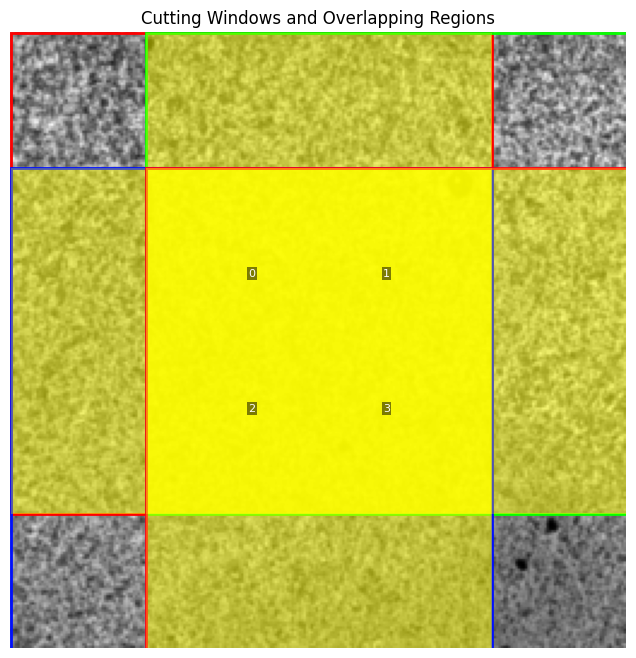

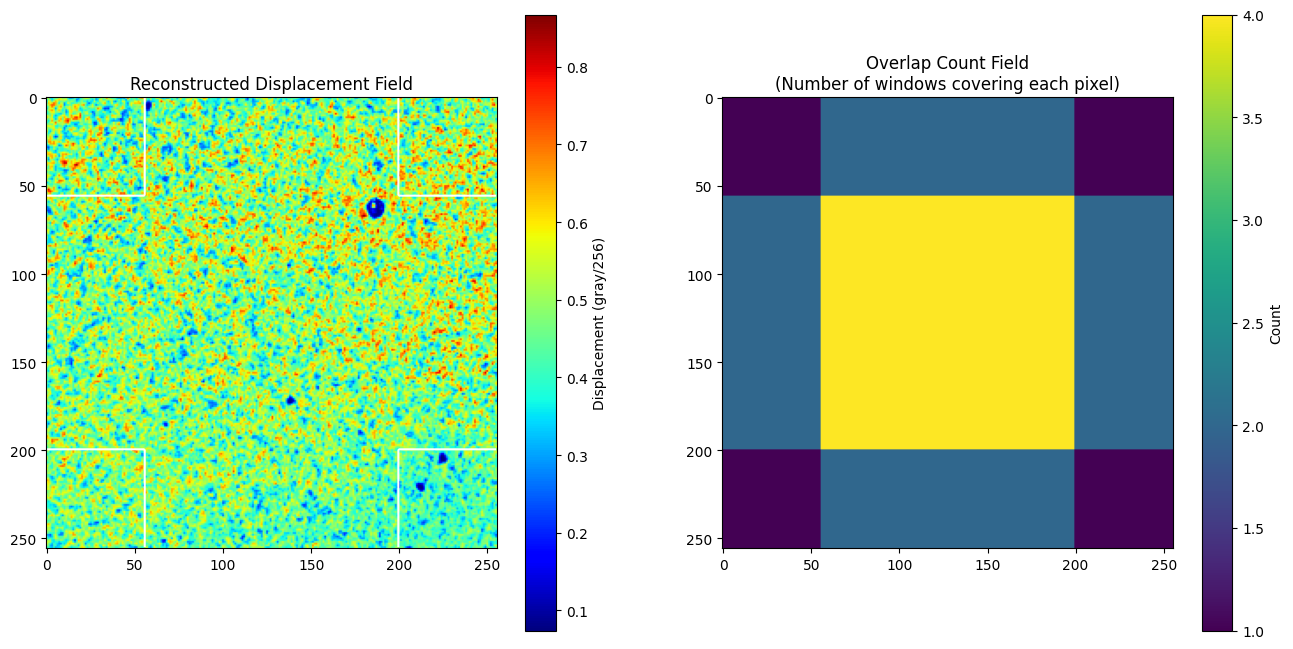

Processing deformed image...
Total cropped images saved: 4
Window 0 overlaps with:
  - Window 2 (down) at (0, 56, 200, 200)
  - Window 1 (right) at (56, 0, 200, 200)
Window 1 overlaps with:
  - Window 3 (down) at (56, 56, 256, 200)
  - Window 0 (left) at (56, 0, 200, 200)
Window 2 overlaps with:
  - Window 0 (up) at (0, 56, 200, 200)
  - Window 3 (right) at (56, 56, 200, 256)
Window 3 overlaps with:
  - Window 1 (up) at (56, 56, 256, 200)
  - Window 2 (left) at (56, 56, 200, 256)
Final displacement field saved as 'final_displacement.npy'


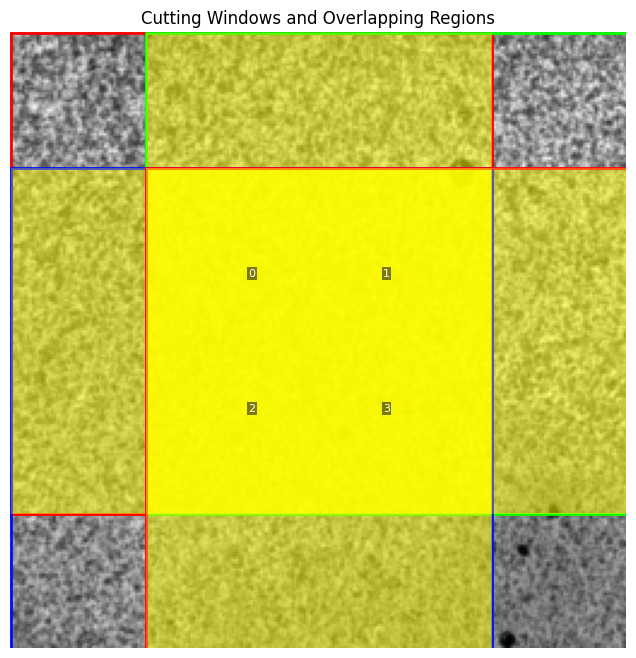

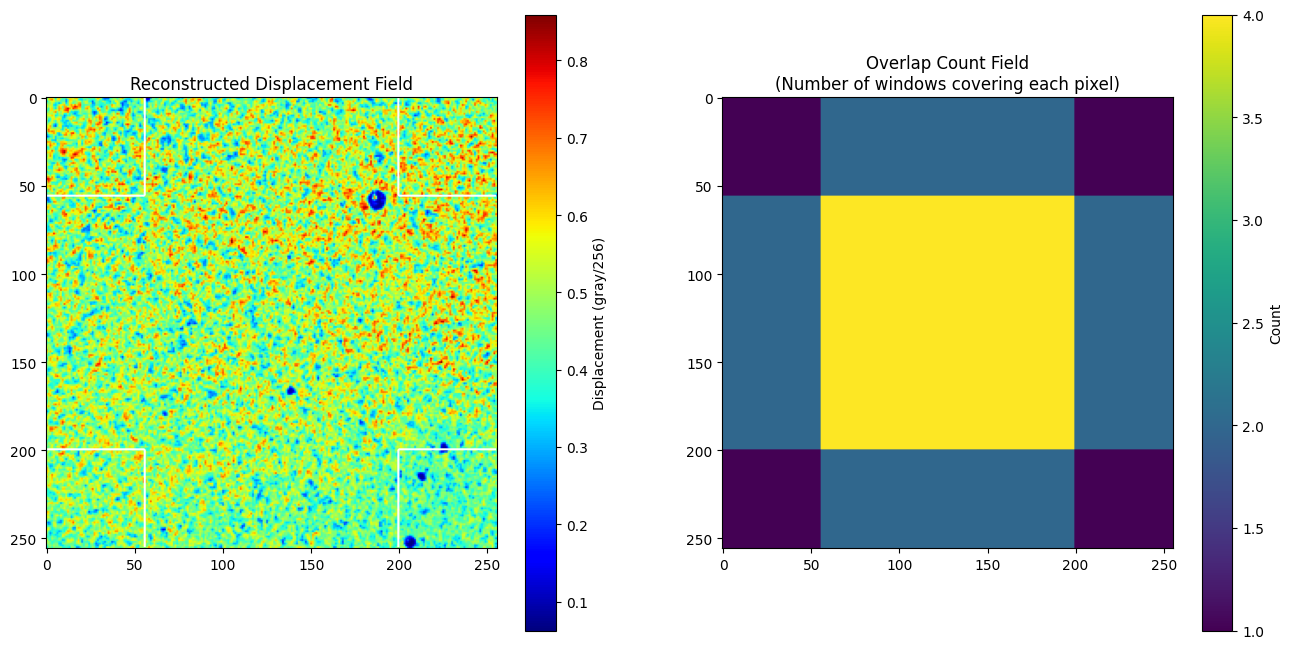

In [30]:
import cv2
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

def load_image_from_url(url, scale_factor=1):
    """
    Downloads an image from the given URL, decodes it, optionally rescales it,
    and converts color images from BGR to RGB.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise Exception("Failed to decode image")
    # If the image is color, convert BGR or BGRA to RGB/RGBA.
    if image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    # Resize if a scale factor other than 1 is provided.
    if scale_factor != 1:
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

def compute_cut_positions(W, w):
    """
    Computes the start and end indices along one dimension for window cutting,
    including overlap if needed.
    """
    N = int(np.ceil(W / w))
    if N == 1:
        return [(0, W)], N
    else:
        overlap = (N * w - W) / (N - 1)
        positions = []
        for i in range(N):
            start = int(round(i * (w - overlap)))
            end = start + w
            if end > W:
                end = W
                start = W - w
            positions.append((start, end))
        return positions, N

def get_cutting_positions(image_width, image_height, window_width, window_height):
    """
    Returns the x and y positions for cutting, along with the number of windows in each dimension.
    """
    x_positions, num_windows_x = compute_cut_positions(image_width, window_width)
    y_positions, num_windows_y = compute_cut_positions(image_height, window_height)
    return x_positions, y_positions, num_windows_x, num_windows_y

def cut_image_from_array(image, window_width, window_height, output_dir, plot_windows=False):
    """
    Cuts the input NumPy array (image) into overlapping windows.
    For each window, the gray value is mapped to a displacement using:
         displacement = gray value / 256.
    All window-level displacements are accumulated into a full-field displacement map.
    In overlapping regions, contributions are averaged.

    The cropped windows and the final displacement field (as a .npy file) are saved.
    If plot_windows=True, plots are generated showing:
      - The cutting windows (with overlapping regions highlighted),
      - The reconstructed displacement field with a contour where overlaps occur,
      - The count field showing how many windows cover each pixel.

    Returns:
      final_disp: The reconstructed displacement field.
      count_field: The count field (number of windows covering each pixel).
    """
    # If the image is color, convert it to grayscale.
    if image.ndim == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image.copy()

    image_height, image_width = gray_img.shape
    x_positions, y_positions, num_windows_x, num_windows_y = get_cutting_positions(
        image_width, image_height, window_width, window_height)

    os.makedirs(output_dir, exist_ok=True)

    windows = []            # To store info about each window.
    overlapping_regions = {}  # To record overlapping region info.

    # Arrays to accumulate displacement and counts.
    disp_field = np.zeros((image_height, image_width), dtype=np.float64)
    count_field = np.zeros((image_height, image_width), dtype=np.float64)

    count = 0
    # Loop over each window position.
    for i, (y_start, y_end) in enumerate(y_positions):
        for j, (x_start, x_end) in enumerate(x_positions):
            window_crop = gray_img[y_start:y_end, x_start:x_end]
            out_filename = os.path.join(output_dir, f"cropped_{count}.png")
            cv2.imwrite(out_filename, window_crop)

            window_info = {
                'index': count,
                'position': (x_start, y_start, x_end, y_end),
                'row': i,
                'col': j
            }
            windows.append(window_info)

            # Compute the displacement field for the window.
            window_disp = window_crop.astype(np.float64) / 256.0
            disp_field[y_start:y_end, x_start:x_end] += window_disp
            count_field[y_start:y_end, x_start:x_end] += 1

            count += 1

    print(f"Total cropped images saved: {count}")

    # Identify overlapping regions between adjacent windows.
    for window in windows:
        idx = window['index']
        i, j = window['row'], window['col']
        x_start, y_start, x_end, y_end = window['position']
        overlaps = []
        # Check immediate neighbors (up, down, left, right).
        neighbors = []
        if i > 0:   # Up
            neighbors.append(('up', i - 1, j))
        if i < num_windows_y - 1:  # Down
            neighbors.append(('down', i + 1, j))
        if j > 0:   # Left
            neighbors.append(('left', i, j - 1))
        if j < num_windows_x - 1:  # Right
            neighbors.append(('right', i, j + 1))
        for direction, ni, nj in neighbors:
            neighbor_idx = ni * num_windows_x + nj
            neighbor_window = windows[neighbor_idx]
            nx_start, ny_start, nx_end, ny_end = neighbor_window['position']
            overlap_x_start = max(x_start, nx_start)
            overlap_x_end = min(x_end, nx_end)
            overlap_y_start = max(y_start, ny_start)
            overlap_y_end = min(y_end, ny_end)
            if overlap_x_start < overlap_x_end and overlap_y_start < overlap_y_end:
                overlaps.append({
                    'neighbor_index': neighbor_window['index'],
                    'direction': direction,
                    'overlap_coords': (overlap_x_start, overlap_y_start, overlap_x_end, overlap_y_end)
                })
        overlapping_regions[idx] = overlaps

    # (Optional) Print overlapping info.
    for idx, overlaps in overlapping_regions.items():
        print(f"Window {idx} overlaps with:")
        for overlap in overlaps:
            print(f"  - Window {overlap['neighbor_index']} ({overlap['direction']}) at {overlap['overlap_coords']}")

    # Reconstruct the final displacement field by averaging overlapping contributions.
    final_disp = disp_field / count_field
    np.save(os.path.join(output_dir, "final_displacement.npy"), final_disp)
    print("Final displacement field saved as 'final_displacement.npy'")

    if plot_windows:
        # Plot the cutting windows over the image.
        fig, ax = plt.subplots(1, figsize=(8,8))
        ax.imshow(gray_img, cmap='gray')
        ax.axis('off')
        num_rects = len(windows)
        colormap = cm.get_cmap('hsv', num_rects)
        for idx, window in enumerate(windows):
            x_start, y_start, x_end, y_end = window['position']
            w = x_end - x_start
            h = y_end - y_start
            color = colormap(idx)
            rect = patches.Rectangle((x_start, y_start), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x_start + w/2, y_start + h/2, str(window['index']),
                    color='white', fontsize=8, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
            # Highlight overlapping regions.
            for overlap in overlapping_regions[window['index']]:
                ox_start, oy_start, ox_end, oy_end = overlap['overlap_coords']
                ow = ox_end - ox_start
                oh = oy_end - oy_start
                overlap_rect = patches.Rectangle((ox_start, oy_start), ow, oh, linewidth=0, facecolor='yellow', alpha=0.3)
                ax.add_patch(overlap_rect)
        plt.title("Cutting Windows and Overlapping Regions")
        plt.show()

        # Plot the reconstructed displacement field and the count (overlap) field.
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        im1 = ax1.imshow(final_disp, cmap='jet')
        ax1.set_title("Reconstructed Displacement Field")
        # Overlay a contour where count_field > 1 (i.e. overlapping regions).
        ax1.contour(count_field, levels=[1.5], colors='white', linewidths=1.5)
        fig2.colorbar(im1, ax=ax1, label="Displacement (gray/256)")

        im2 = ax2.imshow(count_field, cmap='viridis')
        ax2.set_title("Overlap Count Field\n(Number of windows covering each pixel)")
        fig2.colorbar(im2, ax=ax2, label="Count")
        plt.show()

    return final_disp, count_field

# Main script: Process both the reference and deformed images.
if __name__ == "__main__":
    # URLs for the reference and deformed images.
    url_ref = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models/Real_exp_1/images/reference.tif"
    url_def = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models//Real_exp_1/images/deformed_image_1.tif"

    # Load images from URLs.
    ref_image = load_image_from_url(url_ref, scale_factor=1)
    def_image = load_image_from_url(url_def, scale_factor=1)

    # Set window dimensions (adjust as needed).
    window_width, window_height = 200, 200

    # Use separate output directories for each image.
    output_dir_ref = "output_crops_reference"
    output_dir_def = "output_crops_deformed"

    print("Processing reference image...")
    disp_field_ref, count_field_ref = cut_image_from_array(ref_image, window_width, window_height,
                                                           output_dir_ref, plot_windows=True)

    print("Processing deformed image...")
    disp_field_def, count_field_def = cut_image_from_array(def_image, window_width, window_height,
                                                           output_dir_def, plot_windows=True)

    # Display the two reconstructed displacement fields side by side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    im1 = ax1.imshow(disp_field_ref, cmap='jet')
    ax1.set_title("Reference Displacement Field")
    fig.colorbar(im1, ax=ax1, label="Displacement (gray/256)")

    im2 = ax2.imshow(disp_field_def, cmap='jet')
    ax2.set_title("Deformed Displacement Field")
    fig.colorbar(im2, ax=ax2, label="Displacement (gray/256)")

    plt.show()


<ipython-input-36-f3a25615e6c7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))


Total window pairs processed: 4
Window 0 overlaps with:
  - Window 2 (down) at (0, 56, 200, 200)
  - Window 1 (right) at (56, 0, 200, 200)
Window 1 overlaps with:
  - Window 3 (down) at (56, 56, 256, 200)
  - Window 0 (left) at (56, 0, 200, 200)
Window 2 overlaps with:
  - Window 0 (up) at (0, 56, 200, 200)
  - Window 3 (right) at (56, 56, 200, 256)
Window 3 overlaps with:
  - Window 1 (up) at (56, 56, 256, 200)
  - Window 2 (left) at (56, 56, 200, 256)
Final flow field saved as 'final_flow.npy'


<ipython-input-36-f3a25615e6c7>:253: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_rects)


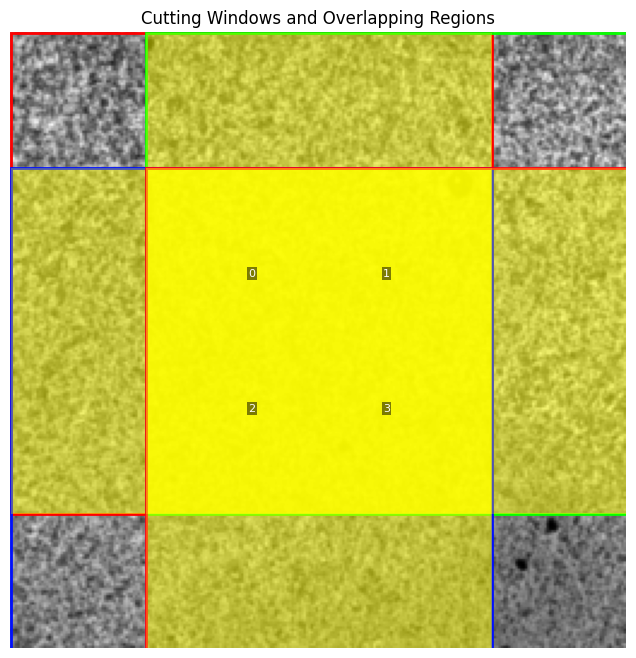

Total processing time: 1.2189 seconds


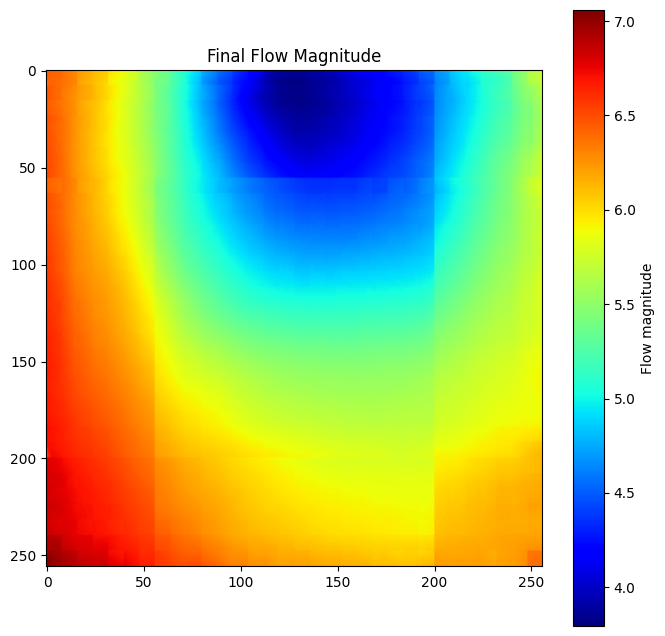

In [36]:
import os
import cv2
import time
import torch
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# ============================
# RAFT-related functions
# ============================
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

def process_img(img, device):
    """Converts a numpy image (H, W, 3) to a torch tensor of shape [1, 3, H, W]."""
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)

def load_model(weights_path, args):
    """Loads the RAFT model with given weights and arguments."""
    model = RAFT(args)
    # You can pass weights_only=True if you trust your file; see the warning for details.
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model

def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):
    """Runs RAFT inference on a pair of images."""
    model.eval()
    with torch.no_grad():
        # Process images
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)
        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init,
                                        upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up
        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init,
                               upsample=upsample, test_mode=test_mode)
            return flow_iters

def get_viz(flo):
    """Converts flow to a visualization image."""
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# A sketchy class to pass to RAFT (adjust parameters as needed)
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr
    def __iter__(self):
        return self
    def __next__(self):
        raise StopIteration

# ============================
# Utility functions for image loading and window cutting
# ============================
def load_image_from_url(url, scale_factor=1):
    """
    Downloads an image from the given URL, decodes it, and (if needed) rescales it.
    This function also converts grayscale images to RGB.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise Exception("Failed to decode image")
    # Convert grayscale (2D) to RGB (3 channels)
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    if scale_factor != 1:
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

def compute_cut_positions(W, w):
    """
    Computes start and end indices for window cutting along one dimension.
    Returns a list of (start, end) positions and the number of windows.
    """
    N = int(np.ceil(W / w))
    if N == 1:
        return [(0, W)], N
    else:
        overlap = (N * w - W) / (N - 1)
        positions = []
        for i in range(N):
            start = int(round(i * (w - overlap)))
            end = start + w
            if end > W:
                end = W
                start = W - w
            positions.append((start, end))
        return positions, N

def get_cutting_positions(image_width, image_height, window_width, window_height):
    """Returns x and y cutting positions and the number of windows in each dimension."""
    x_positions, num_windows_x = compute_cut_positions(image_width, window_width)
    y_positions, num_windows_y = compute_cut_positions(image_height, window_height)
    return x_positions, y_positions, num_windows_x, num_windows_y

# ============================
# Cutting and Flow Reconstruction using RAFT
# ============================
def cut_image_pair_with_flow(ref_image, def_image, window_width, window_height,
                             output_dir, model, device, plot_windows=False):
    """
    Cuts the reference and deformed images (both numpy arrays of shape [H, W, 3])
    into overlapping windows (using the same positions) and runs RAFT inference on
    each window pair to compute a displacement (flow) field.

    The flow for each window (a 2-channel field) is accumulated into a global flow map.
    In overlapping regions, contributions are averaged.

    Cropped window pairs are saved in the output directory.
    Optionally, plots of the window layout (with overlap) and the final flow field
    (flow magnitude) and overlap count field are shown.

    Returns:
      final_flow: A numpy array of shape [H, W, 2] (u and v components).
      count_field: A numpy array of shape [H, W] indicating number of contributions per pixel.
    """
    # Ensure both images have the same shape.
    if ref_image.shape != def_image.shape:
        raise ValueError("Reference and deformed images must have the same shape.")
    # Now we expect ref_image to have 3 channels.
    H, W, _ = ref_image.shape

    # Compute cutting positions.
    x_positions, y_positions, num_windows_x, num_windows_y = get_cutting_positions(W, H, window_width, window_height)
    os.makedirs(output_dir, exist_ok=True)

    windows = []              # To store window info.
    overlapping_regions = {}  # To record overlapping regions.

    # Global flow: two channels (u and v) and a count field.
    global_flow = np.zeros((H, W, 2), dtype=np.float64)
    count_field = np.zeros((H, W), dtype=np.float64)

    count = 0
    for i, (y_start, y_end) in enumerate(y_positions):
        for j, (x_start, x_end) in enumerate(x_positions):
            # Crop the same window from both images.
            ref_window = ref_image[y_start:y_end, x_start:x_end, :]
            def_window = def_image[y_start:y_end, x_start:x_end, :]

            # Save the cropped window pair.
            out_filename_ref = os.path.join(output_dir, f"ref_cropped_{count}.png")
            out_filename_def = os.path.join(output_dir, f"def_cropped_{count}.png")
            cv2.imwrite(out_filename_ref, cv2.cvtColor(ref_window, cv2.COLOR_RGB2BGR))
            cv2.imwrite(out_filename_def, cv2.cvtColor(def_window, cv2.COLOR_RGB2BGR))

            window_info = {
                'index': count,
                'position': (x_start, y_start, x_end, y_end),
                'row': i,
                'col': j
            }
            windows.append(window_info)

            # Run RAFT inference on the window pair.
            flow_low, flow_up = inference(model, ref_window, def_window, device, test_mode=True)
            flow_up = flow_up.squeeze(0)  # Now shape [2, H_pad, W_pad]
            # Crop flow to the original window size.
            h_win = y_end - y_start
            w_win = x_end - x_start
            flow_up = flow_up[:, :h_win, :w_win]
            # Convert to numpy.
            u = flow_up[0].cpu().numpy()
            v = flow_up[1].cpu().numpy()
            window_flow = np.stack((u, v), axis=-1)  # Shape: [h_win, w_win, 2]

            # Accumulate flow and update count.
            global_flow[y_start:y_end, x_start:x_end, :] += window_flow
            count_field[y_start:y_end, x_start:x_end] += 1

            count += 1

    print(f"Total window pairs processed: {count}")

    # Identify overlapping regions (for logging/visualization).
    for window in windows:
        idx = window['index']
        i, j = window['row'], window['col']
        x_start, y_start, x_end, y_end = window['position']
        overlaps = []
        # Check immediate neighbors: up, down, left, right.
        if i > 0:
            overlaps.append(('up', i - 1, j))
        if i < num_windows_y - 1:
            overlaps.append(('down', i + 1, j))
        if j > 0:
            overlaps.append(('left', i, j - 1))
        if j < num_windows_x - 1:
            overlaps.append(('right', i, j + 1))
        actual_overlaps = []
        for direction, ni, nj in overlaps:
            neighbor_idx = ni * num_windows_x + nj
            neighbor_window = windows[neighbor_idx]
            nx_start, ny_start, nx_end, ny_end = neighbor_window['position']
            overlap_x_start = max(x_start, nx_start)
            overlap_x_end = min(x_end, nx_end)
            overlap_y_start = max(y_start, ny_start)
            overlap_y_end = min(y_end, ny_end)
            if overlap_x_start < overlap_x_end and overlap_y_start < overlap_y_end:
                actual_overlaps.append({
                    'neighbor_index': neighbor_window['index'],
                    'direction': direction,
                    'overlap_coords': (overlap_x_start, overlap_y_start, overlap_x_end, overlap_y_end)
                })
        overlapping_regions[idx] = actual_overlaps

    # (Optional) Log overlapping info.
    for idx, overlaps in overlapping_regions.items():
        print(f"Window {idx} overlaps with:")
        for overlap in overlaps:
            print(f"  - Window {overlap['neighbor_index']} ({overlap['direction']}) at {overlap['overlap_coords']}")

    # Reconstruct final flow by averaging contributions.
    final_flow = global_flow / count_field[..., None]
    np.save(os.path.join(output_dir, "final_flow.npy"), final_flow)
    print("Final flow field saved as 'final_flow.npy'")

    if plot_windows:
        # Plot the window layout on the reference image.
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(ref_gray, cmap='gray')
        ax.axis('off')
        num_rects = len(windows)
        colormap = cm.get_cmap('hsv', num_rects)
        for idx, window in enumerate(windows):
            x_start, y_start, x_end, y_end = window['position']
            w = x_end - x_start
            h = y_end - y_start
            color = colormap(idx)
            rect = patches.Rectangle((x_start, y_start), w, h, linewidth=2,
                                     edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x_start + w/2, y_start + h/2, str(window['index']),
                    color='white', fontsize=8, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
            # Highlight overlapping regions.
            for overlap in overlapping_regions[window['index']]:
                ox_start, oy_start, ox_end, oy_end = overlap['overlap_coords']
                ow = ox_end - ox_start
                oh = oy_end - oy_start
                overlap_rect = patches.Rectangle((ox_start, oy_start), ow, oh,
                                                 linewidth=0, facecolor='yellow', alpha=0.3)
                ax.add_patch(overlap_rect)
        plt.title("Cutting Windows and Overlapping Regions")
        plt.show()

        # Plot the final flow magnitude and the overlap count field.
        flow_magnitude = np.linalg.norm(final_flow, axis=2)
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        im1 = ax1.imshow(flow_magnitude, cmap='jet')
        ax1.set_title("Reconstructed Flow Magnitude")
        ax1.contour(count_field, levels=[1.5], colors='white', linewidths=1.5)
        fig2.colorbar(im1, ax=ax1, label="Flow magnitude")
        im2 = ax2.imshow(count_field, cmap='viridis')
        ax2.set_title("Overlap Count Field\n(Number of windows covering each pixel)")
        fig2.colorbar(im2, ax=ax2, label="Count")
        plt.show()

    return final_flow, count_field

# ============================
# Main Script
# ============================
if __name__ == "__main__":
    # URLs for the reference and deformed images.
    url_ref = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models/Real_exp_1/images/reference.tif"
    url_def = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models//Real_exp_1/images/deformed_image_1.tif"

    # Load images from GitHub.
    ref_image = load_image_from_url(url_ref, scale_factor=1)
    def_image = load_image_from_url(url_def, scale_factor=1)

    # Load RAFT model.
    args = Args()
    model = load_model("RAFT-DIC/models/raft-dic_v1.pth", args=args)
    device = 'cuda'  # Change if needed.

    # Set window dimensions (adjust as needed).
    window_width, window_height = 200, 200

    # Choose an output directory.
    output_dir = "output_crops_flow"

    # Process the image pair to compute the displacement (flow) field.
    start_time = time.time()
    final_flow, count_field = cut_image_pair_with_flow(ref_image, def_image,
                                                       window_width, window_height,
                                                       output_dir, model, device,
                                                       plot_windows=True)
    end_time = time.time()
    print(f"Total processing time: {end_time - start_time:.4f} seconds")

    # (Optional) Display the final flow magnitude.
    flow_magnitude = np.linalg.norm(final_flow, axis=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(flow_magnitude, cmap='jet')
    plt.title("Final Flow Magnitude")
    plt.colorbar(label="Flow magnitude")
    plt.show()


<ipython-input-10-072230e967b8>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))


Total window pairs processed: 9
Final flow field saved as 'final_flow.npy'


<ipython-input-10-072230e967b8>:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_rects)


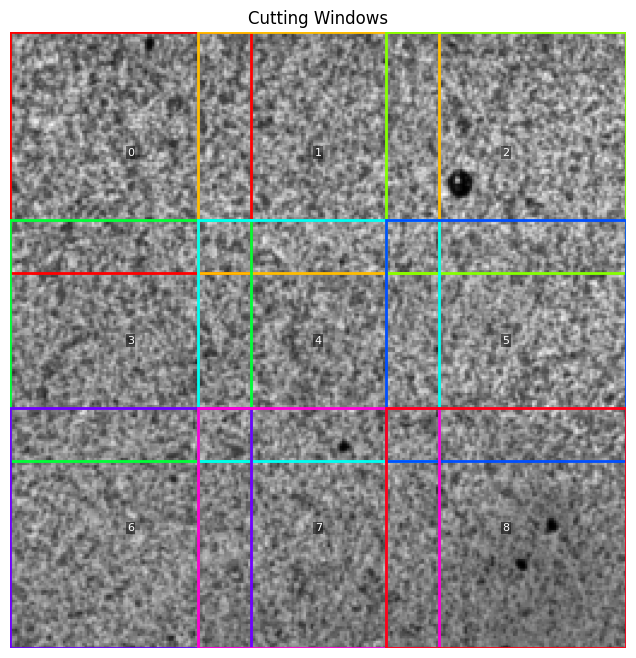


Total processing time: 2.1073 seconds


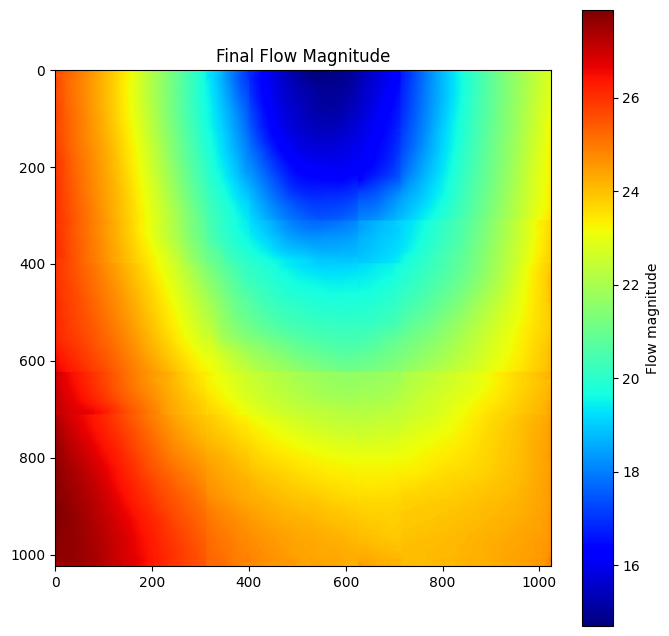

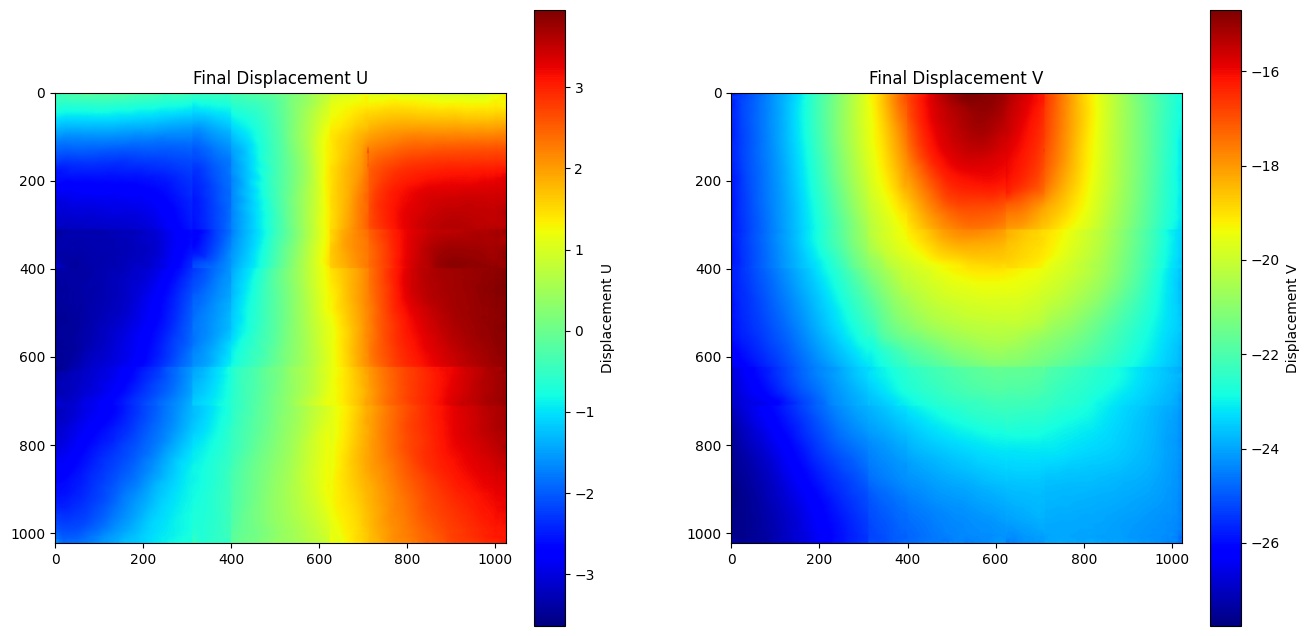

In [10]:
import os
import cv2
import time
import torch
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# ============================
# RAFT-related functions
# ============================
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

def process_img(img, device):
    """Converts a numpy image (H, W, 3) to a torch tensor of shape [1, 3, H, W]."""
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)

def load_model(weights_path, args):
    """Loads the RAFT model with given weights and arguments."""
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model

def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):
    """Runs RAFT inference on a pair of images."""
    model.eval()
    with torch.no_grad():
        # Process images
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)
        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init,
                                        upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up
        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init,
                               upsample=upsample, test_mode=test_mode)
            return flow_iters

def get_viz(flo):
    """Converts flow to a visualization image."""
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# A sketchy class to pass to RAFT (adjust parameters as needed)
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr
    def __iter__(self):
        return self
    def __next__(self):
        raise StopIteration

# ============================
# Utility functions for image loading and window cutting
# ============================
def load_image_from_url(url, scale_factor=1):
    """
    Downloads an image from the given URL, decodes it, and (if needed) rescales it.
    Also converts grayscale images to RGB.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise Exception("Failed to decode image")
    # Convert grayscale (2D) to RGB (3 channels)
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    if scale_factor != 1:
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

def compute_cut_positions(W, w):
    """
    Computes start and end indices for window cutting along one dimension.
    Returns a list of (start, end) positions and the number of windows.
    """
    N = int(np.ceil(W / w))
    if N == 1:
        return [(0, W)], N
    else:
        overlap = (N * w - W) / (N - 1)
        positions = []
        for i in range(N):
            start = int(round(i * (w - overlap)))
            end = start + w
            if end > W:
                end = W
                start = W - w
            positions.append((start, end))
        return positions, N

def get_cutting_positions(image_width, image_height, window_width, window_height):
    """Returns x and y cutting positions and the number of windows in each dimension."""
    x_positions, num_windows_x = compute_cut_positions(image_width, window_width)
    y_positions, num_windows_y = compute_cut_positions(image_height, window_height)
    return x_positions, y_positions, num_windows_x, num_windows_y

# ============================
# Cutting and Flow Reconstruction using RAFT
# ============================
def cut_image_pair_with_flow(ref_image, def_image, window_width, window_height,
                             output_dir, model, device, plot_windows=False):
    """
    Cuts the reference and deformed images (both numpy arrays of shape [H, W, 3])
    into overlapping windows (using the same positions) and runs RAFT inference on
    each window pair to compute a displacement (flow) field.

    The flow for each window (a 2-channel field) is accumulated into a global flow map.
    In overlapping regions (where count > 1), contributions are averaged.
    For non-overlapping regions (count == 1), the flow is kept as-is.

    Cropped window pairs are saved in the output directory.

    Returns:
      final_flow: A numpy array of shape [H, W, 2] (u and v components).
      count_field: A numpy array of shape [H, W] indicating number of contributions per pixel.
    """
    if ref_image.shape != def_image.shape:
        raise ValueError("Reference and deformed images must have the same shape.")
    H, W, _ = ref_image.shape

    x_positions, y_positions, num_windows_x, num_windows_y = get_cutting_positions(W, H, window_width, window_height)
    os.makedirs(output_dir, exist_ok=True)

    windows = []              # To store window info.
    overlapping_regions = {}  # To record overlapping regions.

    # Global flow: two channels (u and v) and a count field.
    global_flow = np.zeros((H, W, 2), dtype=np.float64)
    count_field = np.zeros((H, W), dtype=np.float64)

    count = 0
    for i, (y_start, y_end) in enumerate(y_positions):
        for j, (x_start, x_end) in enumerate(x_positions):
            ref_window = ref_image[y_start:y_end, x_start:x_end, :]
            def_window = def_image[y_start:y_end, x_start:x_end, :]

            out_filename_ref = os.path.join(output_dir, f"ref_cropped_{count}.png")
            out_filename_def = os.path.join(output_dir, f"def_cropped_{count}.png")
            cv2.imwrite(out_filename_ref, cv2.cvtColor(ref_window, cv2.COLOR_RGB2BGR))
            cv2.imwrite(out_filename_def, cv2.cvtColor(def_window, cv2.COLOR_RGB2BGR))

            window_info = {
                'index': count,
                'position': (x_start, y_start, x_end, y_end),
                'row': i,
                'col': j
            }
            windows.append(window_info)

            flow_low, flow_up = inference(model, ref_window, def_window, device, test_mode=True)
            flow_up = flow_up.squeeze(0)  # Now shape [2, H_pad, W_pad]
            h_win = y_end - y_start
            w_win = x_end - x_start
            flow_up = flow_up[:, :h_win, :w_win]
            u = flow_up[0].cpu().numpy()
            v = flow_up[1].cpu().numpy()
            window_flow = np.stack((u, v), axis=-1)  # Shape: [h_win, w_win, 2]

            global_flow[y_start:y_end, x_start:x_end, :] += window_flow
            count_field[y_start:y_end, x_start:x_end] += 1

            count += 1

    print(f"Total window pairs processed: {count}")

    # (Optional) Identify and log overlapping regions here...

    # --- Modified Reconstruction ---
    # For non-overlapping regions (count == 1), keep the flow as is.
    # For overlapping regions (count > 1), average the accumulated flow.
    final_flow = np.where(count_field[..., None] > 1,
                          global_flow / count_field[..., None],
                          global_flow)
    np.save(os.path.join(output_dir, "final_flow.npy"), final_flow)
    print("Final flow field saved as 'final_flow.npy'")
    # --------------------------------

    if plot_windows:
        # Plotting code for window layout and flow magnitude...
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(ref_gray, cmap='gray')
        ax.axis('off')
        num_rects = len(windows)
        colormap = cm.get_cmap('hsv', num_rects)
        for idx, window in enumerate(windows):
            x_start, y_start, x_end, y_end = window['position']
            w = x_end - x_start
            h = y_end - y_start
            color = colormap(idx)
            rect = patches.Rectangle((x_start, y_start), w, h, linewidth=2,
                                     edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x_start + w/2, y_start + h/2, str(window['index']),
                    color='white', fontsize=8, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
        plt.title("Cutting Windows")
        plt.show()

        flow_magnitude = np.linalg.norm(final_flow, axis=2)
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        im1 = ax1.imshow(flow_magnitude, cmap='jet')
        ax1.set_title("Reconstructed Flow Magnitude")
        ax1.contour(count_field, levels=[1.5], colors='white', linewidths=1.5)
        fig2.colorbar(im1, ax=ax1, label="Flow magnitude")
        im2 = ax2.imshow(count_field, cmap='viridis')
        ax2.set_title("Overlap Count Field")
        fig2.colorbar(im2, ax=ax2, label="Count")
        plt.show()

    return final_flow, count_field

# ============================
# Main Script
# ============================
if __name__ == "__main__":
    url_ref = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models/Real_exp_1/images/reference.tif"
    url_def = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models//Real_exp_1/images/deformed_image_1.tif"

    ref_image = load_image_from_url(url_ref, scale_factor=4)
    def_image = load_image_from_url(url_def, scale_factor=4)

    args = Args()
    model = load_model("RAFT-DIC/models/raft-dic_v1.pth", args=args)
    device = 'cuda'

    window_width, window_height = 400, 400
    output_dir = "output_crops_flow"

    start_time = time.time()
    final_flow, count_field = cut_image_pair_with_flow(ref_image, def_image,
                                                       window_width, window_height,
                                                       output_dir, model, device,
                                                       plot_windows=True)
    end_time = time.time()
    print(f"\nTotal processing time: {end_time - start_time:.4f} seconds")

    flow_magnitude = np.linalg.norm(final_flow, axis=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(flow_magnitude, cmap='jet')
    plt.title("Final Flow Magnitude")
    plt.colorbar(label="Flow magnitude")
    plt.show()

# After final_flow is computed (shape: [H, W, 2])
u = final_flow[:, :, 0]
v = final_flow[:, :, 1]

fig, (ax_u, ax_v) = plt.subplots(1, 2, figsize=(16, 8))
im_u = ax_u.imshow(u, cmap='jet')
ax_u.set_title("Final Displacement U")
fig.colorbar(im_u, ax=ax_u, label="Displacement U")

im_v = ax_v.imshow(v, cmap='jet')
ax_v.set_title("Final Displacement V")
fig.colorbar(im_v, ax=ax_v, label="Displacement V")

plt.show()


<ipython-input-9-f90c704d7ddb>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))


Total window pairs processed: 9
Final flow field saved as 'final_flow.npy'


<ipython-input-9-f90c704d7ddb>:204: RuntimeWarning: invalid value encountered in divide
  global_flow / count_field[..., None],
<ipython-input-9-f90c704d7ddb>:217: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_rects)


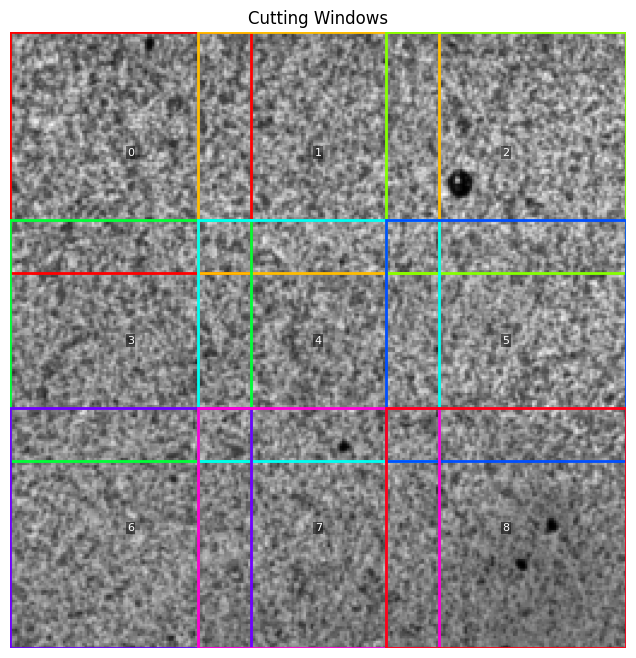

Total processing time: 1.1538 seconds


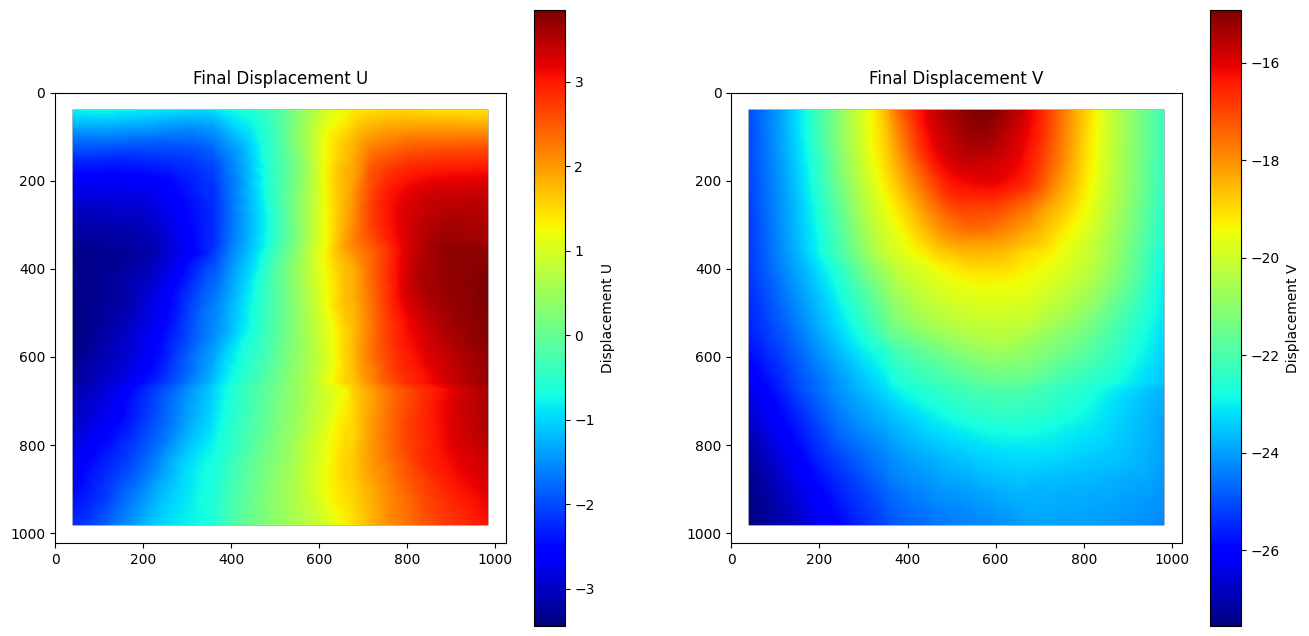

In [9]:
import os
import cv2
import time
import torch
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# ============================
# RAFT-related functions
# ============================
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

def process_img(img, device):
    """Converts a numpy image (H, W, 3) to a torch tensor of shape [1, 3, H, W]."""
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)

def load_model(weights_path, args):
    """Loads the RAFT model with given weights and arguments."""
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model

def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):
    """Runs RAFT inference on a pair of images."""
    model.eval()
    with torch.no_grad():
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)
        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init,
                                        upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up
        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init,
                               upsample=upsample, test_mode=test_mode)
            return flow_iters

def get_viz(flo):
    """Converts flow to a visualization image."""
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# A sketchy class to pass to RAFT (adjust parameters as needed)
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr
    def __iter__(self):
        return self
    def __next__(self):
        raise StopIteration

# ============================
# Utility functions for image loading and window cutting
# ============================
def load_image_from_url(url, scale_factor=1):
    """
    Downloads an image from the given URL, decodes it, and (if needed) rescales it.
    Also converts grayscale images to RGB.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise Exception("Failed to decode image")
    # Convert grayscale (2D) to RGB (3 channels)
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    if scale_factor != 1:
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

def compute_cut_positions(W, w):
    """
    Computes start and end indices for window cutting along one dimension.
    Returns a list of (start, end) positions and the number of windows.
    """
    N = int(np.ceil(W / w))
    if N == 1:
        return [(0, W)], N
    else:
        overlap = (N * w - W) / (N - 1)
        positions = []
        for i in range(N):
            start = int(round(i * (w - overlap)))
            end = start + w
            if end > W:
                end = W
                start = W - w
            positions.append((start, end))
        return positions, N

def get_cutting_positions(image_width, image_height, window_width, window_height):
    """Returns x and y cutting positions and the number of windows in each dimension."""
    x_positions, num_windows_x = compute_cut_positions(image_width, window_width)
    y_positions, num_windows_y = compute_cut_positions(image_height, window_height)
    return x_positions, y_positions, num_windows_x, num_windows_y

# ============================
# Cutting and Flow Reconstruction using RAFT with Validity Masking
# ============================
def cut_image_pair_with_flow(ref_image, def_image, window_width, window_height,
                             output_dir, model, device, plot_windows=False):
    """
    Cuts the reference and deformed images (numpy arrays of shape [H, W, 3])
    into overlapping windows and runs RAFT on each window pair to compute a flow field.

    For each cropped window, only the central 80% (i.e. the area excluding a 10% border on all sides)
    is considered valid. The predicted flow values outside that central region are ignored.

    Each window's valid flow is then indexed to its corresponding position in the original image.
    The final flow at each pixel is the average of all valid contributions. If no valid flow is available,
    that pixel is set to NaN.

    Returns:
      final_flow: A numpy array of shape [H, W, 2] (u and v components).
      count_field: A numpy array of shape [H, W] indicating the number of valid contributions.
    """
    if ref_image.shape != def_image.shape:
        raise ValueError("Reference and deformed images must have the same shape.")
    H, W, _ = ref_image.shape

    x_positions, y_positions, num_windows_x, num_windows_y = get_cutting_positions(W, H, window_width, window_height)
    os.makedirs(output_dir, exist_ok=True)

    windows = []  # To store window info

    # Arrays to accumulate valid flow contributions and counts.
    global_flow = np.zeros((H, W, 2), dtype=np.float64)
    count_field = np.zeros((H, W), dtype=np.float64)

    count = 0
    for i, (y_start, y_end) in enumerate(y_positions):
        for j, (x_start, x_end) in enumerate(x_positions):
            ref_window = ref_image[y_start:y_end, x_start:x_end, :]
            def_window = def_image[y_start:y_end, x_start:x_end, :]

            # Save the cropped window pair.
            out_filename_ref = os.path.join(output_dir, f"ref_cropped_{count}.png")
            out_filename_def = os.path.join(output_dir, f"def_cropped_{count}.png")
            cv2.imwrite(out_filename_ref, cv2.cvtColor(ref_window, cv2.COLOR_RGB2BGR))
            cv2.imwrite(out_filename_def, cv2.cvtColor(def_window, cv2.COLOR_RGB2BGR))

            windows.append({
                'index': count,
                'position': (x_start, y_start, x_end, y_end),
                'row': i,
                'col': j
            })

            # Run RAFT inference on the window pair.
            flow_low, flow_up = inference(model, ref_window, def_window, device, test_mode=True)
            flow_up = flow_up.squeeze(0)  # Now shape: [2, H_pad, W_pad]

            h_win = y_end - y_start
            w_win = x_end - x_start
            flow_up = flow_up[:, :h_win, :w_win]
            u = flow_up[0].cpu().numpy()
            v = flow_up[1].cpu().numpy()
            window_flow = np.stack((u, v), axis=-1)  # Shape: [h_win, w_win, 2]

            # Define the valid region: the central 80% area.
            valid_mask = np.zeros((h_win, w_win), dtype=np.float64)
            valid_start_y = int(0.1 * h_win)# int(0.1 * h_win)
            valid_end_y = int(0.9 * h_win)# int(0.9 * h_win)
            valid_start_x = int(0.1 * w_win)# int(0.1 * w_win)
            valid_end_x = int(0.9 * w_win)# int(0.9 * w_win)
            valid_mask[valid_start_y:valid_end_y, valid_start_x:valid_end_x] = 1.0

            # Accumulate only valid contributions.
            global_flow[y_start:y_end, x_start:x_end, :] += window_flow * valid_mask[..., None]
            count_field[y_start:y_end, x_start:x_end] += valid_mask

            count += 1

    print(f"Total window pairs processed: {count}")

    # Reconstruction: For pixels with valid contributions (count > 0), average them.
    # If no valid contribution is available, assign NaN.
    final_flow = np.where(count_field[..., None] > 0,
                          global_flow / count_field[..., None],
                          np.nan)

    np.save(os.path.join(output_dir, "final_flow.npy"), final_flow)
    print("Final flow field saved as 'final_flow.npy'")

    if plot_windows:
        # (Optional: Plot the window layout over the reference image.)
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(ref_gray, cmap='gray')
        ax.axis('off')
        num_rects = len(windows)
        colormap = cm.get_cmap('hsv', num_rects)
        for idx, window in enumerate(windows):
            x_start, y_start, x_end, y_end = window['position']
            w = x_end - x_start
            h = y_end - y_start
            color = colormap(idx)
            rect = patches.Rectangle((x_start, y_start), w, h, linewidth=2,
                                     edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x_start + w/2, y_start + h/2, str(window['index']),
                    color='white', fontsize=8, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
        plt.title("Cutting Windows")
        plt.show()

    return final_flow, count_field

# ============================
# Main Script
# ============================
if __name__ == "__main__":
    url_ref = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models/Real_exp_1/images/reference.tif"
    url_def = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models//Real_exp_1/images/deformed_image_1.tif"

    ref_image = load_image_from_url(url_ref, scale_factor=4)
    def_image = load_image_from_url(url_def, scale_factor=4)

    args = Args()
    model = load_model("RAFT-DIC/models/raft-dic_v1.pth", args=args)
    device = 'cuda'

    window_width, window_height = 400, 400
    output_dir = "output_crops_flow"

    start_time = time.time()
    final_flow, count_field = cut_image_pair_with_flow(ref_image, def_image,
                                                       window_width, window_height,
                                                       output_dir, model, device,
                                                       plot_windows=True)
    end_time = time.time()
    print(f"Total processing time: {end_time - start_time:.4f} seconds")

    # --- Plot Final Displacement U and V ---
    u = final_flow[:, :, 0]
    v = final_flow[:, :, 1]

    fig, (ax_u, ax_v) = plt.subplots(1, 2, figsize=(16, 8))
    im_u = ax_u.imshow(u, cmap='jet')
    ax_u.set_title("Final Displacement U")
    fig.colorbar(im_u, ax=ax_u, label="Displacement U")
    im_v = ax_v.imshow(v, cmap='jet')
    ax_v.set_title("Final Displacement V")
    fig.colorbar(im_v, ax=ax_v, label="Displacement V")
    plt.show()


C:\Users\13014\AppData\Local\Temp\ipykernel_50140\3525232182.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=

Total window pairs processed: 4


C:\Users\13014\AppData\Local\Temp\ipykernel_50140\3525232182.py:186: RuntimeWarning: invalid value encountered in divide
  global_flow / count_field[..., None],
C:\Users\13014\AppData\Local\Temp\ipykernel_50140\3525232182.py:198: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('hsv', len(windows))


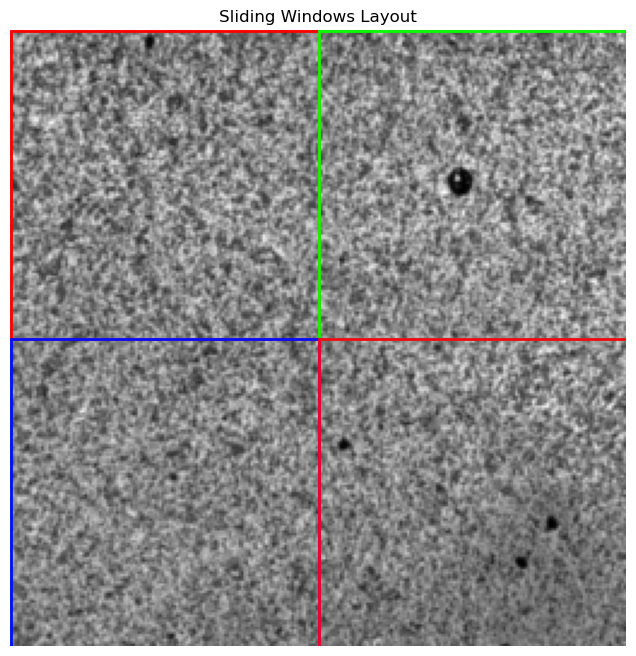

Total processing time: 75.3435 seconds


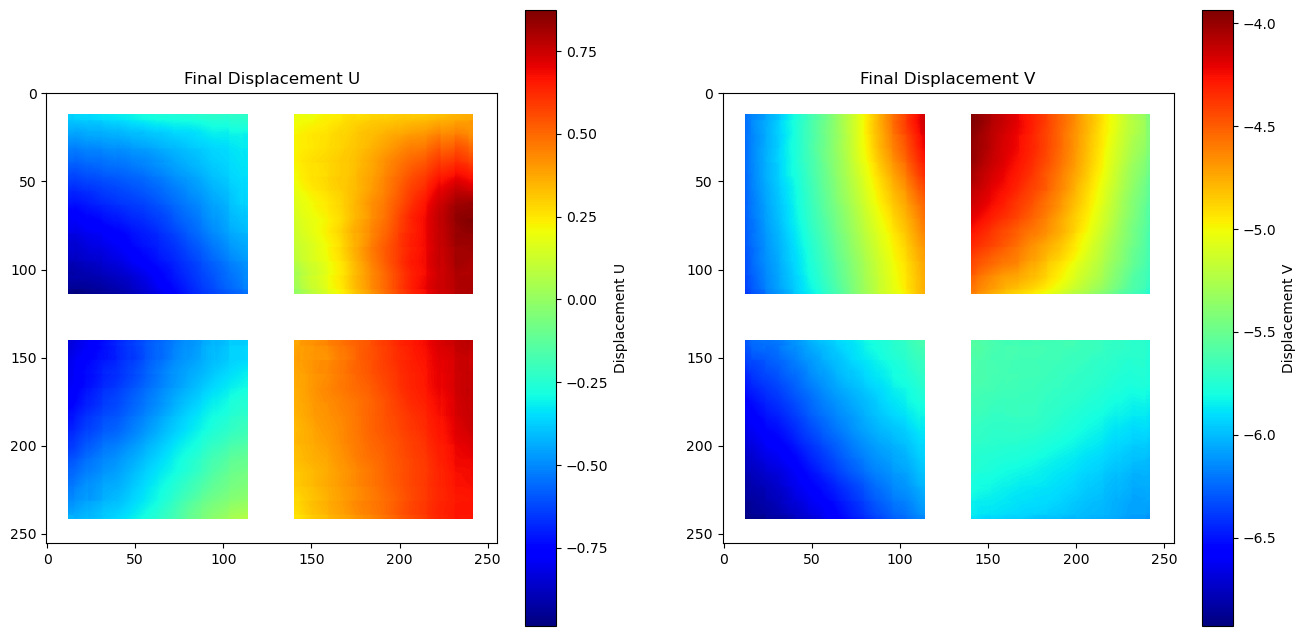

In [3]:
import os
import cv2
import time
import torch
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import sys

sys.path.append("core")
# ============================
# RAFT-related functions
# ============================
from core.raft import RAFT
from core.utils import flow_viz
from core.utils.utils import InputPadder

def process_img(img, device):
    """Converts a numpy image (H, W, 3) to a torch tensor of shape [1, 3, H, W]."""
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)

def load_model(weights_path, args):
    """Loads the RAFT model with given weights and arguments."""
    model = RAFT(args)
    # Note: Consider setting weights_only=True if desired for security.
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model

def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):
    """Runs RAFT inference on a pair of images."""
    model.eval()
    with torch.no_grad():
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)
        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init,
                                        upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up
        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init,
                               upsample=upsample, test_mode=test_mode)
            return flow_iters

def get_viz(flo):
    """Converts flow to a visualization image."""
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# A sketchy class to pass to RAFT (adjust parameters as needed)
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr
    def __iter__(self):
        return self
    def __next__(self):
        raise StopIteration

# ============================
# Utility functions for image loading
# ============================
def load_image_from_url(url, scale_factor=1):
    """
    Downloads an image from the given URL, decodes it, and (if needed) rescales it.
    Also converts grayscale images to RGB.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise Exception("Failed to decode image")
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    if scale_factor != 1:
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

# ============================
# Cutting and Flow Reconstruction with Fixed-Stride Cropping
# ============================
def cut_image_pair_with_flow(ref_image, def_image, output_dir, model, device,
                             crop_size=(128, 128), stride=64, plot_windows=False):
    """
    Crops the reference and deformed images (numpy arrays of shape [H, W, 3])
    using a fixed sliding-window method:
      - Crop size is set to 128x128 pixels.
      - The window moves 64 pixels at a time horizontally and vertically.
      - If there is not enough room at the right or bottom edge, the crop takes the remaining area.

    For each cropped window pair, RAFT is used to predict a flow field.
    Only the central 80% of each crop (i.e. excluding a 10% border) is considered valid.
    Valid predictions are indexed back to their original image positions.

    The final global flow is computed per pixel by averaging the valid contributions.
    If no valid contributions exist for a pixel, its value is set to NaN.

    Returns:
      final_flow: A numpy array of shape [H, W, 2] (u and v components).
      count_field: A numpy array of shape [H, W] indicating the number of valid contributions.
    """
    if ref_image.shape != def_image.shape:
        raise ValueError("Reference and deformed images must have the same shape.")
    H, W, _ = ref_image.shape
    crop_h, crop_w = crop_size

    os.makedirs(output_dir, exist_ok=True)
    windows = []  # To store window info

    # Global accumulators for flow and valid contribution counts.
    global_flow = np.zeros((H, W, 2), dtype=np.float64)
    count_field = np.zeros((H, W), dtype=np.float64)

    count = 0
    # Slide the window over the image.
    for y in range(0, H, stride):
        for x in range(0, W, stride):
            # Determine crop boundaries. If not enough room, use the remaining portion.
            y_end = min(y + crop_h, H)
            x_end = min(x + crop_w, W)

            ref_window = ref_image[y:y_end, x:x_end, :]
            def_window = def_image[y:y_end, x:x_end, :]

            # Save the cropped window pair for reference.
            cv2.imwrite(os.path.join(output_dir, f"ref_cropped_{count}.png"),
                        cv2.cvtColor(ref_window, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(output_dir, f"def_cropped_{count}.png"),
                        cv2.cvtColor(def_window, cv2.COLOR_RGB2BGR))

            windows.append({
                'index': count,
                'position': (x, y, x_end, y_end)
            })

            # Run RAFT inference on the window pair.
            flow_low, flow_up = inference(model, ref_window, def_window, device, test_mode=True)
            flow_up = flow_up.squeeze(0)  # Shape: [2, H_pad, W_pad]
            h_win = y_end - y
            w_win = x_end - x
            flow_up = flow_up[:, :h_win, :w_win]
            u = flow_up[0].cpu().numpy()
            v = flow_up[1].cpu().numpy()
            window_flow = np.stack((u, v), axis=-1)  # Shape: [h_win, w_win, 2]

            # Create a valid mask for the crop:
            # Only the central 80% (exclude a 10% border on all sides) is valid.
            valid_mask = np.zeros((h_win, w_win), dtype=np.float64)
            valid_start_y = int(0.1 * h_win)
            valid_end_y = int(0.9 * h_win)
            valid_start_x = int(0.1 * w_win)
            valid_end_x = int(0.9 * w_win)
            valid_mask[valid_start_y:valid_end_y, valid_start_x:valid_end_x] = 1.0

            # Accumulate valid contributions:
            global_flow[y:y_end, x:x_end, :] += window_flow * valid_mask[..., None]
            count_field[y:y_end, x:x_end] += valid_mask

            count += 1

    print(f"Total window pairs processed: {count}")

    # Final reconstruction:
    # For pixels with valid contributions (count_field > 0), average the accumulated flow.
    # If no valid contributions exist, set that pixel to NaN.
    final_flow = np.where(count_field[..., None] > 0,
                          global_flow / count_field[..., None],
                          np.nan)
    output_dir = "output_crops_flow"
    # Use a crop size of 128x128 and a stride of 64 pixels.
    crop_size = (128, 128)
    stride = 64

    # Plot the window layout on the reference image.
    ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(ref_gray, cmap='gray')
    ax.axis('off')
    colormap = cm.get_cmap('hsv', len(windows))
    for window in windows:
        x_start, y_start, x_end, y_end = window['position']
        w = x_end - x_start
        h = y_end - y_start
        color = colormap(window['index'])
        rect = patches.Rectangle((x_start, y_start), w, h, linewidth=2,
                                    edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    plt.title("Sliding Windows Layout")
    plt.show()

    return final_flow, count_field

# ============================
# Main Script
# ============================
if __name__ == "__main__":
    # URLs for the reference and deformed images.
    url_ref = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models/Real_exp_1/images/reference.tif"
    url_def = "https://github.com/UTAmegg/RAFT-DIC-test/raw/main/20250204_Zach_Comparision_diff_models//Real_exp_1/images/deformed_image_1.tif"

    ref_image = load_image_from_url(url_ref, scale_factor=1)
    def_image = load_image_from_url(url_def, scale_factor=1)

    args = Args()
    model = load_model("models/raft-dic_v1.pth", args=args)
    device = 'cuda'

    output_dir = "output_crops_flow"
    # Use a crop size of 128x128 and a stride of 64 pixels.
    crop_size = (128, 128)
    stride = 128

    start_time = time.time()
    final_flow, count_field = cut_image_pair_with_flow(ref_image, def_image,
                                                       output_dir, model, device,
                                                       crop_size=crop_size, stride=stride,
                                                       plot_windows=True)
    end_time = time.time()
    print(f"Total processing time: {end_time - start_time:.4f} seconds")

    # --- Plot Final Displacement U and V ---
    u = final_flow[:, :, 0]
    v = final_flow[:, :, 1]

    fig, (ax_u, ax_v) = plt.subplots(1, 2, figsize=(16, 8))
    im_u = ax_u.imshow(u, cmap='jet')
    ax_u.set_title("Final Displacement U")
    fig.colorbar(im_u, ax=ax_u, label="Displacement U")
    im_v = ax_v.imshow(v, cmap='jet')
    ax_v.set_title("Final Displacement V")
    fig.colorbar(im_v, ax=ax_v, label="Displacement V")
    plt.show()


### Helper functions

In [18]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder
import time


def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [19]:
model = load_model("RAFT-DIC/models/raft-dic_v1.pth", args=Args())

<ipython-input-18-7590812ff32f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))


### Prediction

In [68]:
# Start time
start_time = time.time()
flow_low, flow_up = inference(model, frame1_resized, frame2_resized, device='cuda')
# End time
end_time = time.time()
# Calculate duration
duration = end_time - start_time
print(f"Time taken: {duration:.4f} seconds")

Time taken: 0.0676 seconds


In [ ]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 32, 32]), torch.Size([1, 2, 256, 256]))

### Display Results

Save as matlap


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


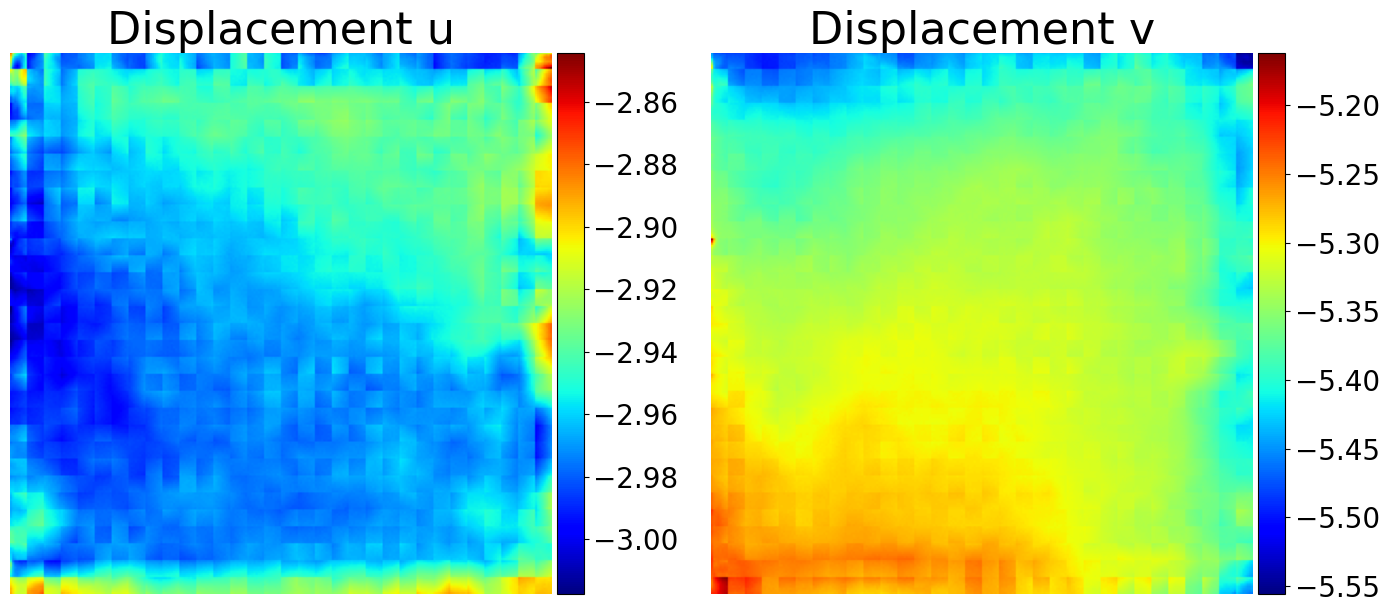

Displacement components saved successfully in Google Drive at: /content/drive/MyDrive/my_custom_folder/
Files saved: displacement_u.mat, displacement_v.mat


In [ ]:
from google.colab import drive
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio
import os

# Mount Google Drive
drive.mount('/content/drive')

def plot_and_save_displacement_components(flow_tensor, save_dir='/content/drive/MyDrive/displacement_results/'):
    """
    Plot displacement components and save them to Google Drive
    Args:
        flow_tensor: Input tensor of shape [1, 2, 432, 360]
        save_dir: Directory in Google Drive to save the .mat files
    """
    # Remove the batch dimension
    flow_tensor = flow_tensor.squeeze(0)  # Now it's [2, 432, 360]

    # Move to CPU if necessary and extract u and v components
    u = flow_tensor[0].cpu().numpy()  # Displacement u (horizontal component)
    v = flow_tensor[1].cpu().numpy()  # Displacement v (vertical component)

    # Create directory in Google Drive if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Save displacement components
    sio.savemat(os.path.join(save_dir, 'Real_exp_2_disp_u_test001.mat'), {'u': u})
    sio.savemat(os.path.join(save_dir, 'Real_exp_2_disp_v_test001.mat'), {'v': v})

    # Plot the displacement components
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # For u (horizontal displacement)
    ax_u = axes[0]
    im_u = ax_u.imshow(u, cmap='jet')
    ax_u.set_title('Displacement u', fontsize=32)
    ax_u.axis('off')

    # Adjust colorbar shape for u
    divider_u = make_axes_locatable(ax_u)
    cax_u = divider_u.append_axes("right", size="5%", pad=0.05)
    cbar_u = fig.colorbar(im_u, cax=cax_u)
    cbar_u.ax.tick_params(labelsize=20)

    # For v (vertical displacement)
    ax_v = axes[1]
    im_v = ax_v.imshow(v, cmap='jet')
    ax_v.set_title('Displacement v', fontsize=32)
    ax_v.axis('off')

    # Adjust colorbar shape for v
    divider_v = make_axes_locatable(ax_v)
    cax_v = divider_v.append_axes("right", size="5%", pad=0.05)
    cbar_v = fig.colorbar(im_v, cax=cax_v)
    cbar_v.ax.tick_params(labelsize=20)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print(f"Displacement components saved successfully in Google Drive at: {save_dir}")
    print(f"Files saved: displacement_u.mat, displacement_v.mat")

# Example usage:
# flow_up = torch.randn(1, 2, 432, 360).cuda()  # Replace with your actual flow tensor
# plot_and_save_displacement_components(flow_up)
# Example with custom directory
plot_and_save_displacement_components(flow_up, save_dir='/content/drive/MyDrive/my_custom_folder/')